# Matrix Multiplication on GPU: Optimizations and Insights

In this notebook, we explore GPU implementations of matrix multiplication.
We analyze various optimization techniques including:

- **Naive implementation**
- **Shared memory tiling**
- **Register tiling (+ shared memory)**

Each method aims to reduce global memory access and increase computation throughput.

## Preparing the required packages and initialisations


In [ ]:
pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
from nvcc4jupyter import set_defaults
set_defaults(compiler_args="-arch=sm_75")

In [ ]:
## Setting the matrix size

In [ ]:
MATRIX_SIZE=8192
SIZE_FILE = open("matrix.size", "w")
SIZE_FILE.write(str(MATRIX_SIZE))
SIZE_FILE.close()

## Naive implementation

In [ ]:
%%cuda
#include <iostream>
#include <cstdlib>
#include <cuda_runtime.h>
#include <fstream>

#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line) {
   if (code != cudaSuccess) {
      std::cerr << "CUDA Error: " << cudaGetErrorString(code)
                << " " << file << ":" << line << std::endl;
      exit(code);
   }
}

__global__ void matMulKernel(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; ++k) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

void matMul(float *A, float *B, float *C, int N, float &ms) {
    float *d_A, *d_B, *d_C;
    size_t size = N * N * sizeof(float);

    CUDA_CHECK(cudaMalloc(&d_A, size));
    CUDA_CHECK(cudaMalloc(&d_B, size));
    CUDA_CHECK(cudaMalloc(&d_C, size));

    CUDA_CHECK(cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice));

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((N + 15) / 16, (N + 15) / 16);

    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    matMulKernel<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, N);

    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));

    CUDA_CHECK(cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost));

    CUDA_CHECK(cudaFree(d_A));
    CUDA_CHECK(cudaFree(d_B));
    CUDA_CHECK(cudaFree(d_C));
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
}


int main(int argc, char **argv) {

    std::ifstream inSize("matrix.size");
    if (inSize.is_open() == false) {
        std::cerr << "Unable to open input file!" << std::endl;
        return 1;
    }

    int N;
    inSize >> N;

    const int size = N * N;
    float *A = new float[size];
    float *B = new float[size];
    float *C = new float[size];

    for (int i = 0; i < size; ++i) {
        A[i] = static_cast<float>(rand()) / RAND_MAX;
        B[i] = static_cast<float>(rand()) / RAND_MAX;
    }

    float ms = 0;
    matMul(A, B, C, N, ms);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << cudaGetErrorString(err) << std::endl;
    }

    std::cout << "Naive: N = " << N << ", kernel time = " << ms << " ms" << std::endl;

    std::ofstream out("naive_time.time"); // No append flag = overwrite
    if (out.is_open()) {
        out << "Naive: N = " << N << ", kernel time = " << ms << " ms" << std::endl;
        out.close();
    } else {
        std::cerr << "Unable to open output file!" << std::endl;
    }

    std::cout << "Sample outputs: C[0][0] = " << C[0] << ", C[N/2][N/2] = "
              << C[(N/2) * N + (N/2)] << ", C[N-1][N-1] = " << C[(N-1)*N + (N-1)] << std::endl;

    delete[] A;
    delete[] B;
    delete[] C;
    return 0;
}

Naive: N = 8192, kernel time = 2666.56 ms
Sample outputs: C[0][0] = 2052.07, C[N/2][N/2] = 2059.19, C[N-1][N-1] = 2070.76



## Shared Memory Tiling

This kernel uses shared memory to reduce redundant loads from global memory. Each block loads a tile of A and B into shared memory, computes the partial result, then synchronizes before moving to the next tile.

In [ ]:
%%cuda
#include <iostream>
#include <cstdlib>
#include <cuda_runtime.h>
#include <fstream>

#define TILE_SIZE 16

#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line) {
   if (code != cudaSuccess) {
      std::cerr << "CUDA Error: " << cudaGetErrorString(code)
                << " " << file << ":" << line << std::endl;
      exit(code);
   }
}

__global__ void matMulKernel(float *A, float *B, float *C, int N) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];

    int row = blockIdx.y * TILE_SIZE + threadIdx.y;
    int col = blockIdx.x * TILE_SIZE + threadIdx.x;

    float val = 0.0;

    for (int t = 0; t < (N + TILE_SIZE - 1) / TILE_SIZE; ++t) {
        if (row < N && t * TILE_SIZE + threadIdx.x < N)
            tileA[threadIdx.y][threadIdx.x] = A[row * N + t * TILE_SIZE + threadIdx.x];
        else
            tileA[threadIdx.y][threadIdx.x] = 0;

        if (t * TILE_SIZE + threadIdx.y < N && col < N)
            tileB[threadIdx.y][threadIdx.x] = B[(t * TILE_SIZE + threadIdx.y) * N + col];
        else
            tileB[threadIdx.y][threadIdx.x] = 0;

        __syncthreads();

        for (int i = 0; i < TILE_SIZE; ++i)
            val += tileA[threadIdx.y][i] * tileB[i][threadIdx.x];

        __syncthreads();
    }

    if (row < N && col < N)
        C[row * N + col] = val;
}

void matMul(float *A, float *B, float *C, int N, float &ms) {
    float *d_A, *d_B, *d_C;
    size_t size = N * N * sizeof(float);

    CUDA_CHECK(cudaMalloc(&d_A, size));
    CUDA_CHECK(cudaMalloc(&d_B, size));
    CUDA_CHECK(cudaMalloc(&d_C, size));

    CUDA_CHECK(cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice));

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((N + 15) / 16, (N + 15) / 16);

    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    matMulKernel<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, N);

    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));

    CUDA_CHECK(cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost));

    CUDA_CHECK(cudaFree(d_A));
    CUDA_CHECK(cudaFree(d_B));
    CUDA_CHECK(cudaFree(d_C));
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
}


int main(int argc, char **argv) {

    std::ifstream inSize("matrix.size");
    if (inSize.is_open() == false) {
        std::cerr << "Unable to open input file!" << std::endl;
        return 1;
    }

    int N;
    inSize >> N;

    const int size = N * N;
    float *A = new float[size];
    float *B = new float[size];
    float *C = new float[size];

    for (int i = 0; i < size; ++i) {
        A[i] = static_cast<float>(rand()) / RAND_MAX;
        B[i] = static_cast<float>(rand()) / RAND_MAX;
    }

    float ms = 0;
    matMul(A, B, C, N, ms);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << cudaGetErrorString(err) << std::endl;
    }

    std::cout << "Shared: N = " << N << ", kernel time = " << ms << " ms" << std::endl;

    std::ofstream out("shared_time.time"); // No append flag = overwrite
    if (out.is_open()) {
        out << "Shared: N = " << N << ", kernel time = " << ms << " ms" << std::endl;
        out.close();
    } else {
        std::cerr << "Unable to open output file!" << std::endl;
    }

    std::cout << "Sample outputs: C[0][0] = " << C[0] << ", C[N/2][N/2] = "
              << C[(N/2) * N + (N/2)] << ", C[N-1][N-1] = " << C[(N-1)*N + (N-1)] << std::endl;

    delete[] A;
    delete[] B;
    delete[] C;
    return 0;
}

Shared: N = 8192, kernel time = 1740.72 ms
Sample outputs: C[0][0] = 2052.07, C[N/2][N/2] = 2059.19, C[N-1][N-1] = 2070.76



## Register Tiling

Instead of computing one output per thread, each thread computes a small **tile** of outputs  (using registers). This leverages fast register access.

In [ ]:
%%cuda
#include <iostream>
#include <cstdlib>
#include <cuda_runtime.h>
#include <fstream>

#define TILE_SIZE 16

#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line) {
   if (code != cudaSuccess) {
      std::cerr << "CUDA Error: " << cudaGetErrorString(code)
                << " " << file << ":" << line << std::endl;
      exit(code);
   }
}

__global__ void matMulKernel(const float* A, const float* B, float* C, int N) {
    __shared__ float tileA[TILE_SIZE][TILE_SIZE];
    __shared__ float tileB[TILE_SIZE][TILE_SIZE];

    // Compute global row/col for 2x2 tile
    int row = blockIdx.y * TILE_SIZE + threadIdx.y * 2;
    int col = blockIdx.x * TILE_SIZE + threadIdx.x * 2;

    float c00 = 0, c01 = 0, c10 = 0, c11 = 0;

    for (int t = 0; t < (N + TILE_SIZE - 1) / TILE_SIZE; ++t) {
        // Load 2 rows of A into shared memory
        for (int i = 0; i < 2; ++i) {
            int r = row + i;
            int c = t * TILE_SIZE + threadIdx.x * 2;
            if (r < N && c < N) tileA[threadIdx.y * 2 + i][threadIdx.x * 2]     = A[r * N + c];
            else                tileA[threadIdx.y * 2 + i][threadIdx.x * 2]     = 0.0f;
            if (r < N && c + 1 < N) tileA[threadIdx.y * 2 + i][threadIdx.x * 2 + 1] = A[r * N + c + 1];
            else                    tileA[threadIdx.y * 2 + i][threadIdx.x * 2 + 1] = 0.0f;
        }

        // Load 2 columns of B into shared memory
        for (int i = 0; i < 2; ++i) {
            int r = t * TILE_SIZE + threadIdx.y * 2;
            int c = col + i;
            if (r < N && c < N) tileB[threadIdx.y * 2][threadIdx.x * 2 + i]     = B[r * N + c];
            else                tileB[threadIdx.y * 2][threadIdx.x * 2 + i]     = 0.0f;
            if (r + 1 < N && c < N) tileB[threadIdx.y * 2 + 1][threadIdx.x * 2 + i] = B[(r + 1) * N + c];
            else                    tileB[threadIdx.y * 2 + 1][threadIdx.x * 2 + i] = 0.0f;
        }

        __syncthreads();

        // Multiply shared memory tiles
        for (int k = 0; k < TILE_SIZE; ++k) {
            float a0 = tileA[threadIdx.y * 2][k];
            float a1 = tileA[threadIdx.y * 2 + 1][k];
            float b0 = tileB[k][threadIdx.x * 2];
            float b1 = tileB[k][threadIdx.x * 2 + 1];

            c00 += a0 * b0;
            c01 += a0 * b1;
            c10 += a1 * b0;
            c11 += a1 * b1;
        }

        __syncthreads();
    }

    // Write back to global memory
    if (row < N && col < N) {
        C[row * N + col] = c00;
        if (col + 1 < N) C[row * N + col + 1] = c01;
        if (row + 1 < N) C[(row + 1) * N + col] = c10;
        if (row + 1 < N && col + 1 < N) C[(row + 1) * N + col + 1] = c11;
    }
}


void matMul(float *A, float *B, float *C, int N, float &ms) {
    float *d_A, *d_B, *d_C;
    size_t size = N * N * sizeof(float);

    CUDA_CHECK(cudaMalloc(&d_A, size));
    CUDA_CHECK(cudaMalloc(&d_B, size));
    CUDA_CHECK(cudaMalloc(&d_C, size));

    CUDA_CHECK(cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice));

    dim3 threadsPerBlock(TILE_SIZE / 2, TILE_SIZE / 2);
    dim3 numBlocks((N + TILE_SIZE - 1) / TILE_SIZE, (N + TILE_SIZE - 1) / TILE_SIZE);


    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    matMulKernel<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, N);

    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));

    CUDA_CHECK(cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost));

    CUDA_CHECK(cudaFree(d_A));
    CUDA_CHECK(cudaFree(d_B));
    CUDA_CHECK(cudaFree(d_C));
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
}


int main(int argc, char **argv) {

    std::ifstream inSize("matrix.size");
    if (inSize.is_open() == false) {
        std::cerr << "Unable to open input file!" << std::endl;
        return 1;
    }

    int N;
    inSize >> N;

    const int size = N * N;
    float *A = new float[size];
    float *B = new float[size];
    float *C = new float[size];

    for (int i = 0; i < size; ++i) {
        A[i] = static_cast<float>(rand()) / RAND_MAX;
        B[i] = static_cast<float>(rand()) / RAND_MAX;
    }

    float ms = 0;
    matMul(A, B, C, N, ms);

    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << cudaGetErrorString(err) << std::endl;
    }

    std::cout << "Register: N = " << N << ", kernel time = " << ms << " ms" << std::endl;

    std::ofstream out("register_time.time"); // No append flag = overwrite
    if (out.is_open()) {
        out << "Register: N = " << N << ", kernel time = " << ms << " ms" << std::endl;
        out.close();
    } else {
        std::cerr << "Unable to open output file!" << std::endl;
    }

    std::cout << "Sample outputs: C[0][0] = " << C[0] << ", C[N/2][N/2] = "
              << C[(N/2) * N + (N/2)] << ", C[N-1][N-1] = " << C[(N-1)*N + (N-1)] << std::endl;


    delete[] A;
    delete[] B;
    delete[] C;
    return 0;
}

Register: N = 8192, kernel time = 1655.33 ms
Sample outputs: C[0][0] = 2052.07, C[N/2][N/2] = 2059.19, C[N-1][N-1] = 2070.76



## Benchmarking

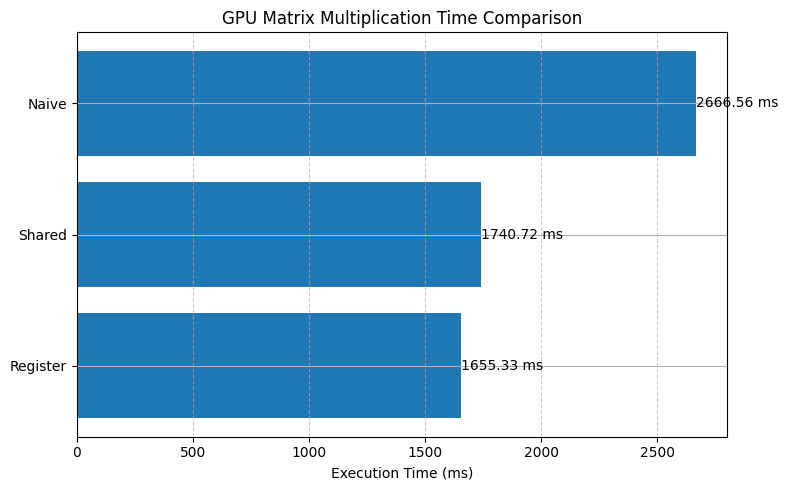

In [ ]:
import re
import matplotlib.pyplot as plt

# Files you want to parse
time_files = [
    "naive_time.time",
    "shared_time.time",
    "register_time.time",
]

timings = []

# Extract label and time from each file
for file in time_files:
    with open(file, 'r') as f:
        content = f.read()
        match = re.search(r"^\s*([A-Za-z0-9+ ]+):.*?kernel time\s*=\s*([0-9.]+)", content)
        if match:
            label = match.group(1)
            time = float(match.group(2))
            timings.append((label, time))
        else:
            print(f"Warning: Couldn't parse {file}")

# Unzip
labels, times = zip(*timings)

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.barh(labels, times)
plt.xlabel("Execution Time (ms)")
plt.title("GPU Matrix Multiplication Time Comparison")
plt.gca().invert_yaxis()

# Annotate bars
for bar, t in zip(bars, times):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
             f"{t:.2f} ms", va='center')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.grid(True)
plt.show()
